In [6]:
import sys 
import torch
sys.path.append('../..')

import os
import pytorch_lightning as pl
from src.datasets.vqa_rad_dataset import VQRadDataModule
from src.models.multimodal.flamingo_module import FlamingoModule
from tqdm import tqdm

from pytorch_lightning import Trainer, seed_everything
import torchvision.transforms as T

from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning import loggers as pl_loggers

seed_everything(42, workers=True)

img_mean = (0.48,0.48,0.48)
img_std = (0.265,0.265,0.265)

transforms = {'train':
    T.Compose(
    [
        # T.RandomRotation(10),
        T.ToTensor(),
        # T.Normalize(mean=img_mean, std=img_std)
    ]),
    'val':
    T.Compose(
    [
        # T.RandomRotation(10),
        T.ToTensor(),
        # T.Normalize(mean=img_mean, std=img_std)
    ]),
    'test':
    T.Compose(
    [
        T.ToTensor(),
        # T.Normalize(mean=img_mean, std=img_std)
    ])
}


Global seed set to 42


In [22]:
# Hyperparameters
NUM_DATA_WORKERS  = 8
ONLY_IMAGES = False
BATCH_SIZE = 1
NUM_EPOCHS = 10
LIMIT_NUM_SAMPLES = None

ACCELERATOR = "gpu"
DEVICES = [7]
# ACCELERATOR = "cpu"
# DEVICES = 1
DATASET_ROOT = '/home/andrei/mlmi/home/mlmi-matthias/Data/VQA_RAD_preprocessed/'
PRETRAINED_CLIP_PATH = '/home/andrei/mlmi/home/mlmi-matthias/Caghan/pretrained_models/PubMedCLIP_ViT32.pth'
PRETRAINED_GPT2_PATH = "/home/andrei/mlmi/home/mlmi-matthias/Caghan/pretrained_models/gpt2-pytorch_model.bin"

IMAGE_TYPE = "jpg"
SHUFFLE = True
TOKENIZER  = "gpt2"
LOAD_IN_MEM = True
PREPROCESSED = True

vqarad_datamodule = VQRadDataModule(
                                batch_size=BATCH_SIZE, transforms=transforms, root=DATASET_ROOT,
                                limit_num_samples=LIMIT_NUM_SAMPLES, num_workers=NUM_DATA_WORKERS, shuffle=SHUFFLE,
                                tokenizer="gpt2", preprocessed=PREPROCESSED, load_in_memory=LOAD_IN_MEM
)

Loading all images into memory... for train
Loading all images into memory... for val
Loading all images into memory... for test


In [23]:
train_loader = vqarad_datamodule.train_dataloader()
val_loader = vqarad_datamodule.val_dataloader()
test_loader = vqarad_datamodule.test_dataloader()

In [24]:
for batch in train_loader:
    cur_images = batch['image']
    print(cur_images.shape)
    break

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [8]:
# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for batch in tqdm(train_loader):
    psum    += batch["image"].sum(axis = [0, 2, 3])
    psum_sq += (batch["image"] ** 2).sum(axis = [0, 2, 3])

###### FINAL CALCULATIONS

# pixel count
count = len(train_loader) * 224 * 224

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

100%|██████████| 18/18 [00:00<00:00, 28.91it/s]

mean: tensor([15.1931, 15.1972, 15.1990])
std:  tensor([nan, nan, nan])


In [13]:
# MODEL HPRAMS
VOCAB_SIZE_OF_TOKENIZER = 50257 # mimic_datamodule.train_dataset.tokenizer.vocab_size
LANGUAGE_MODEL = 'gpt2'
NUM_TOKENS = VOCAB_SIZE_OF_TOKENIZER +3 if LANGUAGE_MODEL=="gpt2" else 31092
FLAMINGO_EMBED_DIM = 768
DEPTH = 12
NUM_HEADS = 8
ATT_HEAD_DIM = 64
CROOS_ATT_EVERY=3
MEDIA_TOKEN_ID = vqarad_datamodule.train_dataset.tokenizer.\
    all_special_ids[vqarad_datamodule.train_dataset.tokenizer.all_special_tokens.index('<image>')]
PERCEIVER_NUM_LATENTS = 64
PERCEIVER_DEPTH = 2
IMAGE_ENCODER = "clip"



print("LANGUAGE_MODEL : ",LANGUAGE_MODEL, "\n"
        "NUM_TOKENS : ",NUM_TOKENS, "\n"
        "FLAMINGO_EMBED_DIM : ",FLAMINGO_EMBED_DIM, "\n"
        "DEPTH : ",DEPTH, "\n"
        "NUM_HEADS : ",NUM_HEADS, "\n"
        "ATT_HEAD_DIM : ",ATT_HEAD_DIM, "\n"
        "CROOS_ATT_EVERY : ",CROOS_ATT_EVERY, "\n"
        "MEDIA_TOKEN_ID : ",MEDIA_TOKEN_ID, "\n"
        "PERCEIVER_NUM_LATENTS : ",PERCEIVER_NUM_LATENTS, "\n"
        "PERCEIVER_DEPTH : ",PERCEIVER_DEPTH, "\n"
        "IMAGE_ENCODER : ",IMAGE_ENCODER, "\n"
        "PRETRAINED_CLIP_PATH : ",PRETRAINED_CLIP_PATH, "\n"
        "PRETRAINED_GPT2_PATH : ",PRETRAINED_GPT2_PATH, "\n")


hyperparams = {
    'pretrained_clip_path': PRETRAINED_CLIP_PATH,
    'warmup_steps': 0,
    'num_tokens': NUM_TOKENS,
    'dim': FLAMINGO_EMBED_DIM,
    'depth': DEPTH,
    'num_heads': NUM_HEADS,
    'dim_head': ATT_HEAD_DIM,
    'cross_attn_every': CROOS_ATT_EVERY,
    'media_token_id': MEDIA_TOKEN_ID,
    'perceiver_num_latents': PERCEIVER_NUM_LATENTS,
    'perceiver_depth': PERCEIVER_DEPTH,
    'image_encoder': IMAGE_ENCODER,
    'language_model': LANGUAGE_MODEL,
    'pretrained_gpt2_path': PRETRAINED_GPT2_PATH,
}


model = FlamingoModule(**hyperparams)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpdscv7_i1
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpdscv7_i1/_remote_module_non_sriptable.py


LANGUAGE_MODEL :  gpt2 
NUM_TOKENS :  50260 
FLAMINGO_EMBED_DIM :  768 
DEPTH :  12 
NUM_HEADS :  8 
ATT_HEAD_DIM :  64 
CROOS_ATT_EVERY :  3 
MEDIA_TOKEN_ID :  50258 
PERCEIVER_NUM_LATENTS :  64 
PERCEIVER_DEPTH :  2 
IMAGE_ENCODER :  clip 
PRETRAINED_CLIP_PATH :  /home/andrei/mlmi/home/mlmi-matthias/Caghan/pretrained_models/PubMedCLIP_ViT32.pth 
PRETRAINED_GPT2_PATH :  /home/andrei/mlmi/home/mlmi-matthias/Caghan/pretrained_models/gpt2-pytorch_model.bin 

Pretrained clip is being loaded
Flamingo is being initialized with  gpt2  as language model
GPT 2 Weights are loading...
Loaded GPT2 weights and Embeddings num_weights loaded :  156


In [15]:
CHECKPOINT_PATH = "/home/andrei/mlmi/home/mlmi-matthias/Andrei/mlmi-vqa/notebooks/lightning_logs/flamingo_clip_GPT2_FT_vqaRAD_bestModel_lr1e-4/checkpoints/epoch=5-val_loss=1.35-other_metric=0.00.ckpt"
START_FROM_CHECKPOINT = True

if START_FROM_CHECKPOINT:
    print("Pretrained Flamingo Model is loaded from checkpoint : ",CHECKPOINT_PATH)
    model.load_state_dict(torch.load(CHECKPOINT_PATH)["state_dict"])

Pretrained Flamingo Model is loaded from checkpoint :  /home/andrei/mlmi/home/mlmi-matthias/Andrei/mlmi-vqa/notebooks/lightning_logs/flamingo_clip_GPT2_FT_vqaRAD_bestModel_lr1e-4/checkpoints/epoch=5-val_loss=1.35-other_metric=0.00.ckpt


In [18]:
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
from transformers import GPT2Tokenizer
import numpy as np

from torch import nn as nn
import torch.nn.functional as F
def generate(image, context, cur_model, ntok=20):
    for _ in range(ntok):
        out = cur_model({'image': image,'input_ids': context })
        logits = out[:, -1, :]
        indices_to_remove = logits < torch.topk(logits, 10)[0][..., -1, None]
        logits[indices_to_remove] = np.NINF
        next_tok = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1).squeeze(1)
        context = torch.cat([context, next_tok.unsqueeze(-1)], dim=-1)
    return context


tokenizer = vqarad_datamodule.train_dataset.tokenizer

In [25]:
val_loader_iter = iter(val_loader)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
batch = next(val_loader_iter)
val_img = batch["image"]
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' answer:')]) 
out = generate(val_img, context, model, ntok=20)
print("Model out : ",tokenizer.decode(out[0]))
print("Correct Answer: " + batch["answer"][0])

Model out :  <|endoftext|> <image> question: is there evidence of intraparenchymal lung nodules? answer: No <EOC>[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]
Correct Answer: No


In [30]:
batch = next(val_loader_iter)
val_img = batch["image"]
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' answer:')]) 
out = generate(val_img, context, model, ntok=20)
print("Model out : ",tokenizer.decode(out[0]))
print("Correct Answer: " + batch["answer"][0])

Model out :  <|endoftext|> <image> question: How was this film taken? answer: X? Answer: X-ray <EOC>[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]
Correct Answer: PA


In [31]:
batch = next(val_loader_iter)
val_img = batch["image"]
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' answer:')]) 
out = generate(val_img, context, model, ntok=20)
print("Model out : ",tokenizer.decode(out[0]))
print("Correct Answer: " + batch["answer"][0])

Model out :  <|endoftext|> <image> question: Are there rib fractures present? answer: No <EOC>[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]
Correct Answer: No


Model out :  <|endoftext|> <image> question: What is the patient's gender? answer: Right upper lobe <EOC>[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]
Correct Answer: Female


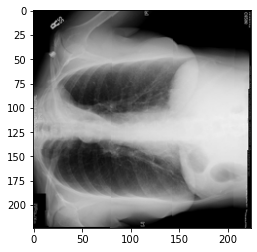

In [43]:
batch = next(val_loader_iter)
val_img = batch["image"]
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' answer:')]) 
out = generate(val_img, context, model, ntok=20)
print("Model out : ",tokenizer.decode(out[0]))
print("Correct Answer: " + batch["answer"][0])
plt.imshow(torch.swapaxes(val_img.squeeze(0),0,2), cmap='Greys')

Model out :  <|endoftext|> <image> question: Are there rib fractures present? answer: No <EOC>[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]
Correct Answer: No


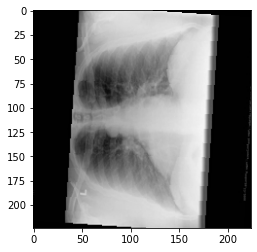

In [38]:
batch = next(val_loader_iter)
val_img = batch["image"]
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' answer:')]) 
out = generate(val_img, context, model, ntok=20)
print("Model out : ",tokenizer.decode(out[0]))
print("Correct Answer: " + batch["answer"][0])
plt.imshow(torch.swapaxes(val_img.squeeze(0),0,2), cmap='Greys')

Model out :  <|endoftext|> <image> question: Where is the diffuse pleural thickening? answer: X to the findings? Answer: Chest <EOC>[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]
Correct Answer: Right lung


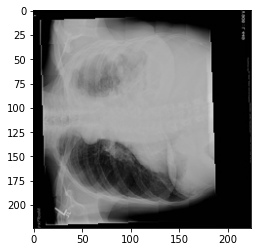

In [39]:
batch = next(val_loader_iter)
val_img = batch["image"]
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' answer:')]) 
out = generate(val_img, context, model, ntok=20)
print("Model out : ",tokenizer.decode(out[0]))
print("Correct Answer: " + batch["answer"][0])
plt.imshow(torch.swapaxes(val_img.squeeze(0),0,2), cmap='Greys')

Model out :  <|endoftext|> <image> question: Is there a pleural effusion answer: Bilateral <EOC>[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]
Correct Answer: No


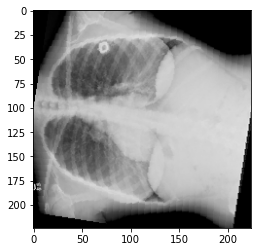

In [44]:
batch = next(val_loader_iter)
val_img = batch["image"]
context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' answer:')]) 
out = generate(val_img, context, model, ntok=20)
print("Model out : ",tokenizer.decode(out[0]))
print("Correct Answer: " + batch["answer"][0])
plt.imshow(torch.swapaxes(val_img.squeeze(0),0,2), cmap='Greys')